# 🔍 Project Overview
This notebook presents a complete end-to-end optimization and deployment pipeline for a GPT-2-style small language model (SLM), with the goal of achieving efficient inference on resource-constrained environments.

## 📦 Part 1: Load & Profile GPT-2 in FP16 on GPU (NVIDIA T4)
- **Objective**: Load the GPT-2 model with half-precision (FP16) to reduce memory footprint and accelerate inference.

- **Hardware**: NVIDIA T4 GPU (16 GB GDDR6).

- **Tasks**:
    - Load a pretrained GPT-2 model using Hugging Face Transformers.
    - Convert weights to FP16.
    - Measure baseline performance: latency, throughput, VRAM usage.
    - Use torch.profiler to generate flame graphs for bottleneck analysis.
 

### Environment Setup
#### Hardware & Software Requirements


*   GPU: NVIDIA T4 (16 GB GDDR6 VRAM, 320 GB/s bandwidth, 320 Turing Tensor Cores)
*   CPU: 2 vCPUs, 4 GB RAM for final inference stage
*   Python Version: ≥ 3.8
*   Libraries:
    * torch
    * transformers
    * optimum
    * datasets
    * tqdm, matplotlib, and psutil for progress bars, plotting, and memory checks

### Install the libraries

We run `nvidia-smi` to check if GPU is visible and ready to use. We then install the necessary libraries. 

In [ ]:
!nvidia-smi

### Logging into Huggingface and Authincating 

In [ ]:
from huggingface_hub import login
HF_TOKEN='USER_TOKEN'  # Replace with your actual Hugging Face token

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please save the token first.")

Successfully logged in to Hugging Face!


### Check for GPU

In [2]:
# Check PyTorch GPU availability and VRAM
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"CUDA Device: {gpu_name}")
    print(f"Total GPU VRAM: {total_mem:.2f} GB")
else:
    raise RuntimeError("CUDA GPU not available! Ensure a T4 is attached.")


CUDA Device: Tesla T4
Total GPU VRAM: 14.57 GB


**Expected Output**



```
CUDA Device: Tesla T4
Total GPU VRAM: 14.74 GB
```



###  Load GPT2 & Tokenizer

Loads a GPT-2 model and tokenizer in FP16 precision and moves the model to the appropriate device.

    How to implement:
    - Use the `transformers` library to load the tokenizer and model using the provided model ID.
    - Set the model's data type to FP16 (float16).
    - Use `torch` to detect whether a CUDA-compatible GPU is available.
    - Move the model to the selected device (GPU if available, else CPU).
    - Return both the tokenizer and model.

    Args:
        model_id (str): The model name or path to load from Hugging Face (default: "gpt2").

    Returns:
        tuple: A tuple containing the tokenizer and the model.

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def load_fp16_model(model_id="gpt2"):
    """
    Loads a GPT-2 model and tokenizer in FP16 precision and moves the model to the appropriate device.

    How to implement:
    - Use the `transformers` library to load the tokenizer and model using the provided model ID.
    - Set the model's data type to FP16 (float16).
    - Use `torch` to detect whether a CUDA-compatible GPU is available.
    - Move the model to the selected device (GPU if available, else CPU).
    - Return both the tokenizer and model.

    Args:
        model_id (str): The model name or path to load from Hugging Face (default: "gpt2").

    Returns:
        tuple: A tuple containing the tokenizer and the model.
    """
    # TODO: Implement this function following the hints above
    pass

2025-06-14 16:11:15.900863: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 16:11:15.917251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749917475.938123    9688 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749917475.944367    9688 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749917475.960105    9688 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loaded model 'gpt2' in FP16 on cuda


#### Lets write a test case to see if we have successfully loaded the model. Run the below cell. **Do not change anything**

In [4]:
def test_load_fp16_model():
    # Simple test prompt
    prompt = "The future of AI is"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate text
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_length=20,
            do_sample=False
        )

    # Decode output
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print("\n=== Test Output ===")
    print("Prompt:", prompt)
    print("Generated:", generated_text)

    # Basic correctness checks
    assert model.dtype == torch.float16, "Model is not in FP16"
    assert str(model.device) == str(inputs["input_ids"].device), "Model and input are on different devices"
    assert prompt in generated_text, "Generated text does not include the prompt"
    print("\nTest passed ✅")


test_load_fp16_model()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== Test Output ===
Prompt: The future of AI is
Generated: The future of AI is uncertain.

The future of AI is uncertain.

The future

Test passed ✅


#### You should see an output like this

Loaded model 'gpt2' in FP16 on cuda

=== Test Output ===
Prompt: The future of AI is
Generated: The future of AI is uncertain.

The future of AI is uncertain.

The future

Test passed ✅

### Load WikiTest-2 Dataset

Loads a small subset of the WikiText-2 dataset for training and validation.

    How to implement:
    - Use the `load_dataset` function from the `datasets` library.
    - Load the "wikitext-2-raw-v1" dataset.
    - Specify the split using slice notation strings (e.g., "train[:100]").
    - Return both the training and validation subsets.
    - Optionally, print how many examples are loaded in each split.

    Args:
        train_split (str): Slice of the training data to load.
        valid_split (str): Slice of the validation data to load.

    Returns:
        tuple: A tuple containing the training and validation datasets.

In [ ]:
from datasets import load_dataset

def load_wikitext_dataset(train_split="train[:100]", valid_split="validation[:200]"):
    """
    Loads a small subset of the WikiText-2 dataset for training and validation.

    How to implement:
    - Use the `load_dataset` function from the `datasets` library.
    - Load the "wikitext-2-raw-v1" dataset.
    - Specify the split using slice notation strings (e.g., "train[:100]").
    - Return both the training and validation subsets.
    - Optionally, print how many examples are loaded in each split.

    Args:
        train_split (str): Slice of the training data to load.
        valid_split (str): Slice of the validation data to load.

    Returns:
        tuple: A tuple containing the training and validation datasets.
    """
    # TODO: Load and return the sliced WikiText-2 dataset as described above
    pass

Validation samples: 200
Fine-tune samples: 100


#### Lets write a test case to see if we have successfully loaded the dataset. Run the below cell. **Do not change anything**

In [6]:
def test_load_wikitext_dataset():
    print("\n=== Sample Examples ===")
    print("Train[0]:", train_ds[1]['text'])
    print("Valid[0]:", valid_ds[1]['text'])

    # Checks
    assert len(train_ds) == 100, "Train dataset does not contain 100000 samples"
    assert len(valid_ds) == 200, "Validation dataset does not contain 200 samples"
    assert isinstance(train_ds[0]['text'], str), "Train sample is not a string"
    assert isinstance(valid_ds[0]['text'], str), "Validation sample is not a string"

    print("\nTest passed ✅")

test_load_wikitext_dataset()


=== Sample Examples ===
Train[0]:  = Valkyria Chronicles III = 

Valid[0]:  = Homarus gammarus = 


Test passed ✅


#### You should see an output something like this

=== Sample Examples === \
Train[0]:  = Valkyria Chronicles III = 

Valid[0]:  = Homarus gammarus = 


Test passed ✅

### Baseline FP16 GPU Profiling

Measures the average inference latency on GPU in milliseconds per token.

    How to implement:
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Tokenize the input prompt and move it to the GPU.
    4. Perform a short warm-up generation (e.g., 10 tokens) to stabilize performance.
    5. Use `time.time()` to measure how long it takes to generate `max_new_tokens`.
    6. Use `torch.cuda.synchronize()` before and after timing to ensure accurate GPU measurements.
    7. Return the average time per token (in ms) by dividing elapsed time by `max_new_tokens`.

    Args:
        model: A causal language model loaded on GPU.
        tokenizer: The tokenizer used for encoding the input prompt.
        prompt (str): The prompt string for text generation.
        max_new_tokens (int): Number of tokens to generate during measurement.

    Returns:
        float: Latency in milliseconds per generated token.

Below this cell, implement `measure_latency_gpu(...)` step by step following the docstring hints.

In [ ]:
import time
import torch
import math
from tqdm.auto import tqdm
from torch.profiler import profile, record_function, ProfilerActivity

def measure_latency_gpu(model, tokenizer, prompt, max_new_tokens=50):
    """
    Measures the average inference latency on GPU in milliseconds per token.
    How to implement:
    
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Tokenize the input prompt and move it to the GPU.
    4. Perform a short warm-up generation (e.g., 10 tokens) to stabilize performance.
    5. Use `time.time()` to measure how long it takes to generate `max_new_tokens`.
    6. Use `torch.cuda.synchronize()` before and after timing to ensure accurate GPU measurements.
    7. Return the average time per token (in ms) by dividing elapsed time by `max_new_tokens`.

    Args:
        model: A causal language model loaded on GPU.
        tokenizer: The tokenizer used for encoding the input prompt.
        prompt (str): The prompt string for text generation.
        max_new_tokens (int): Number of tokens to generate during measurement.

    Returns:
        float: Latency in milliseconds per generated token.
    """
    # TODO: Implement latency measurement using the steps described above
    pass

# Measure latency using the same token-by-token loop
prompt = "The future of AI is"
max_new_tokens = 50
start_time = time.time()
baseline_latency = measure_latency_gpu(model, tokenizer, prompt)
torch.cuda.synchronize()
elapsed = time.time() - start_time
latency_per_token = (elapsed * 1000) / max_new_tokens
print(f"Greedy Generation with Progress: {latency_per_token:.2f} ms/token")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Greedy Generation with Progress: 10.66 ms/token


#### Next, lets measure the Perplexity, the following function computes the perplexity of a language model on a given dataset.

    How to implement:
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Loop through each example in the dataset.
    4. For each example:
        - Skip if the text is empty or just whitespace.
        - Tokenize the text with truncation (max length = 512).
        - Move input tensors to the appropriate device and ensure their dtype is Long.
        - Set `labels = input_ids` to compute loss for causal LM.
        - Perform a forward pass under `torch.no_grad()` to get the loss.
        - Accumulate the total loss scaled by the sequence length.
    5. After the loop, divide total loss by the total number of tokens.
    6. Return the exponential of the average loss as perplexity.
       (Avoid division by zero if all texts are skipped.)

    Args:
        model: A pretrained causal language model.
        tokenizer: Corresponding tokenizer for the model.
        dataset: A Hugging Face dataset containing a "text" field.

    Returns:
        float: The perplexity score (exp of average loss per token).

In [ ]:
import time
import torch
import math
from transformers import AutoModelForCausalLM, AutoTokenizer

def compute_perplexity(model, tokenizer, dataset):
    """
    Computes the perplexity of a language model on a given dataset.

    How to implement:
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Loop through each example in the dataset.
    4. For each example:
        - Skip if the text is empty or just whitespace.
        - Tokenize the text with truncation (max length = 512).
        - Move input tensors to the appropriate device and ensure their dtype is Long.
        - Set `labels = input_ids` to compute loss for causal LM.
        - Perform a forward pass under `torch.no_grad()` to get the loss.
        - Accumulate the total loss scaled by the sequence length.
    5. After the loop, divide total loss by the total number of tokens.
    6. Return the exponential of the average loss as perplexity.
       (Avoid division by zero if all texts are skipped.)

    Args:
        model: A pretrained causal language model.
        tokenizer: Corresponding tokenizer for the model.
        dataset: A Hugging Face dataset containing a "text" field.

    Returns:
        float: The perplexity score (exp of average loss per token).
    """
    # TODO: Implement perplexity calculation using the steps described above
    pass

baseline_ppl = compute_perplexity(model, tokenizer, valid_ds)
print(f"Baseline FP16 GPU Perplexity: {baseline_ppl:.2f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Baseline FP16 GPU Perplexity: 40.03


#### Lets call the `mdoel.generate` function to see the  VRAM usage 

In [9]:
# 3. Check peak GPU memory usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.generate(**tokenizer("warm up", return_tensors="pt").to(device), max_new_tokens=5)
peak_vram = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Baseline FP16 GPU Peak VRAM: {peak_vram:.2f} GB")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Baseline FP16 GPU Peak VRAM: 0.45 GB


#### Lets generate a flame graph and visualize it using Tensorboard 

In [ ]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from torch.profiler import tensorboard_trace_handler
from datetime import datetime
import os

def profile_model_for_tensorboard(model, tokenizer, prompt, device, log_dir="tb_logs", run_name="pruned_fp16"):
    """
    Profiles the inference of a PyTorch model and saves a trace for visualization in TensorBoard.

    Args:
        model (torch.nn.Module): The PyTorch model to profile.
        tokenizer: The tokenizer used to process the prompt.
        prompt (str): The input prompt string for model inference.
        device (str or torch.device): Device to run the model on ("cuda" or "cpu").
        log_dir (str): Directory where TensorBoard logs will be saved.
        run_name (str): Subdirectory name for this profiling run.

    Returns:
        None. Writes profiling logs to disk and prints the save location.

    TODO:
        1. Tokenize the input prompt and move it to the specified device.
        2. Use `torch.profiler.profile()` to record inference performance.
        3. Export profiling data in TensorBoard-compatible format using `tensorboard_trace_handler`.
    """
    # TODO: Implement profile_model_for_tensorboard using the steps described above
    pass

profile_model_for_tensorboard(model, tokenizer, prompt="The future of AI is", device="cuda", run_name="baseline_fp16")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ Profiling complete. View flame graph via:
   tensorboard --logdir=tb_logs


#### We will also do a profiler trace to measure the baseline inference

In [11]:
# 4. Rrecord a torch.profiler trace for baseline inference
with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("baseline_fp16_inference"):
        _ = model.generate(**tokenizer(prompt, return_tensors="pt").to(device), max_new_tokens=50)
prof.export_chrome_trace("baseline_fp16_trace.json")
print("Exported baseline_fp16_trace.json")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Exported baseline_fp16_trace.json


## ✂️ Part 2: Structured Attention Head Pruning & Fine-Tuning
**Objective:** Reduce the number of parameters by pruning redundant attention heads while maintaining accuracy.

**Methodology:**

    - Prune a fixed percentage (e.g., 20%) of attention heads per layer.
    - Fine-tune the pruned model on a small corpus to recover lost performance.

- **Metrics Tracked:**

    - Change in latency and memory usage.
    - Perplexity before and after fine-tuning.


## How do we Prune it?
1. Prune 25 % of Heads in GPT-2
GPT-2 architecture:

- Hidden size: 768
- Layers: 12 transformer blocks
- Heads per layer: 12
- Total heads: 12 × 12 = 144

Pruning plan:

- 25 % of heads ⇒ 0.25 × 12 = 3 heads removed per layer
- Remaining heads: 12 − 3 = 9 per layer ⇒ 9 × 12 = 108 total heads
- Rough parameter reduction:

    - GPT-2 has ~117 M parameters overall
    - Attention-head weights constitute ≈15 % of that (~17 M)
    - Removing 25 % of head parameters cuts ~4 M weights → new model size ≈113 M (≈3 % total reduction)

📈 Why head pruning?

- Multi-head attention learns some heads that contribute very little—pruning them can cut compute and memory.
- Warm-up and inference speed improve (often 10–20 %), with only minor losses in perplexity.

In [ ]:
def prune_attention_heads(model, prune_fraction=0.2):
    """
    Prunes a fraction of attention heads from each layer of the model and casts it back to FP16.

    How to implement:
    1. Retrieve the number of transformer layers and the number of attention heads per layer
       using the model’s configuration (e.g., `model.config.n_layer` and `model.config.n_head`).
    2. Compute how many heads to prune per layer (e.g., 20% of total heads).
    3. Construct a dictionary where each key is a layer index, and the value is a list of
       head indices to prune in that layer (e.g., [0, 1, 2, 3]).
    4. Call the `prune_heads()` method on `model.base_model` and pass the dictionary.
    5. After pruning, cast the model back to `float16` using `.half()` to reduce memory usage.

    Args:
        model: The transformer-based model with attention heads to prune.
        prune_fraction (float): The fraction of heads to prune per layer (default is 0.2 for 20%).

    Returns:
        The pruned model in float16.
    """
    # TODO: Implement pruning logic following the instructions above
    pass

model = prune_attention_heads(model)

Pruned 20% of heads per layer


### Lets write a test case to see if we have successfully pruned the model. Run the below cell. Do not change anything

In [13]:
import torch
from transformers import GPT2LMHeadModel

def test_prune_attention_heads():
    # 1) Load GPT-2 small in FP16
    model = GPT2LMHeadModel.from_pretrained("gpt2").half().to("cpu")
    
    orig_n_head  = model.config.n_head    # 12
    orig_n_layer = model.config.n_layer   # 12
    prune_fraction = 0.2                  # 20%
    heads_pruned = int(orig_n_head * prune_fraction)  # floor(12 * 0.2) = 2
    expected_heads = orig_n_head - heads_pruned       # 12 - 2 = 10
    
    # 2) Apply pruning
    pruned_model = prune_attention_heads(model, prune_fraction=prune_fraction)
    
    # 3) All params still float16
    for p in pruned_model.parameters():
        assert p.dtype == torch.float16, "⚠️ Parameter not in float16"
    
    # 4) Check each layer’s Attention module
    for i in range(orig_n_layer):
        attn = pruned_model.transformer.h[i].attn
        
        # num_heads should be reduced
        assert attn.num_heads == expected_heads, (
            f"Layer {i} has {attn.num_heads} heads, expected {expected_heads}"
        )
        
        # pruned_heads set should match {0, 1, …, heads_pruned-1}
        assert attn.pruned_heads == set(range(heads_pruned)), (
            f"Layer {i} pruned {attn.pruned_heads}, expected {set(range(heads_pruned))}"
        )
    
    print("test_prune_attention_heads passed ✅")

# Run it
test_prune_attention_heads()


Pruned 20% of heads per layer
test_prune_attention_heads passed ✅


#### You should see an output something like this

Pruned 20% of heads per layer\
test_prune_attention_heads passed ✅

### How do we Fine-Tune the Pruned Model for 1 Epoch :


Here we will:

1. **Configure the tokenizer & model**  
   - Reuse the EOS token for padding so that causal LM padding behaves correctly.  
   - Ensure `pad_token_id` is set in both the tokenizer and model config.

2. **Prepare the data**  
   - Tokenize and truncate each example to a fixed length (max 512 tokens).  
   - Copy the inputs to `labels` for next-token prediction.  
   - Use `DataCollatorForLanguageModeling` (with `mlm=False`) to dynamically batch sequences for causal LM.

3. **Set up training arguments**  
   - Disable external logging (`WANDB_DISABLED` and `report_to="none"`).  
   - Choose hyperparameters: epochs, batch size, learning rate, logging frequency.  
   - Enable FP16 training via `fp16=True` under the hood.

4. **Handle precision & device placement**  
   - Cast the pruned model back to FP32 (`model.float()`) before handing off to the Trainer.  
   - Let the Trainer automatically manage FP16 conversion, gradient scaling, and device transfers.

5. **Launch training**  
   - Instantiate a `Trainer` with the pruned model, tokenized dataset, and collator.  
   - Call `trainer.train()` to fine-tune on your custom text split.

> 🔧 **Learning Objectives**  
> - See how to integrate pruned models into a standard 🤗 Trainer workflow  
> - Understand padding for causal LMs and label shifting  
> - Observe mixed-precision training setup and benefits  

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import os
import torch # Import torch explicitly

os.environ["WANDB_DISABLED"] = "true"

def prepare_tokenizer_for_padding(tokenizer, model):
    """
    Prepares the tokenizer and model for consistent padding behavior during fine-tuning.

    How to implement:
    - Set the tokenizer's pad token to be the same as its end-of-sequence (eos) token.
    - Update the model's configuration to use this same pad token ID.

    Args:
        tokenizer: The Hugging Face tokenizer.
        model: The language model whose config needs to be updated.

    Returns:
        None (modifies tokenizer and model in-place)
    """
    # TODO: Implement as per instructions above
    pass

In [ ]:
def tokenize_dataset(dataset, tokenizer):
    """
    Tokenizes a dataset of text examples for causal language modeling.

    How to implement:
    - Use `tokenizer` to tokenize the "text" field.
    - Truncate examples to a maximum length (e.g., 512 tokens).
    - Pad sequences using max length.
    - Copy `input_ids` to a new key `labels` for causal language modeling.
    - Remove the raw "text" column from the result.

    Args:
        dataset: Hugging Face Dataset containing a "text" field.
        tokenizer: The tokenizer to use.

    Returns:
        A tokenized dataset suitable for training.
    """

    # TODO: Map a tokenization function over the dataset with batching enabled
    pass

In [ ]:
def create_training_arguments(output_dir="gpt2_finetuned", learning_rate=1e-5):
    """
    Creates Hugging Face TrainingArguments for model fine-tuning.

    How to implement:
    - Set a small batch size (e.g., 1–2) to handle large models.
    - Use 1 epoch for quick experimentation.
    - Disable saving and logging to external tools (e.g., wandb).
    - Disable column removal to retain all inputs.

    Args:
        output_dir (str): Directory to save model outputs.
        learning_rate (float): Learning rate for fine-tuning.

    Returns:
        TrainingArguments object.
    """
    # TODO: Create and return a TrainingArguments instance
    pass 


In [ ]:
def run_fine_tuning(model, training_args, tokenized_train, tokenizer):
    """
    Fine-tunes the given model using the Hugging Face Trainer.

    How to implement:
    - Set up a data collator for language modeling (no masked LM).
    - Initialize the Trainer with model, args, dataset, and collator.
    - Call `.train()` to begin fine-tuning.

    Args:
        model: The transformer model to fine-tune.
        training_args: TrainingArguments object.
        tokenized_train: Tokenized training dataset.
        tokenizer: Tokenizer used to create the collator.

    Returns:
        Trainer instance after training.
    """
    # # TODO: Configure the trainer and start training
    # pass

#### Lets call of these functions to finetune the pruned model

In [18]:
prepare_tokenizer_for_padding(tokenizer, model)
tokenized_train = tokenize_dataset(train_ds, tokenizer)
tokenized_valid = tokenize_dataset(valid_ds, tokenizer)
training_args = create_training_arguments()
trainer = run_fine_tuning(model, training_args, tokenized_train, tokenizer)

Step,Training Loss
50,5.690800
100,4.216900
150,4.104000
200,3.920600
250,3.568000
300,3.368800
350,3.222700
400,3.357100
450,3.410300
500,3.204500


### Benchmark Pruned Model on GPU:

After fine-tuning, re-measure latency, perplexity, and GPU VRAM usage for the pruned FP16 model using the same functions we wrote above to measure latency etc.

In [19]:
start_time = time.time()
pruned_latency = measure_latency_gpu(model, tokenizer, prompt)
torch.cuda.synchronize()
elapsed = time.time() - start_time
latency_per_token = (elapsed * 1000) / max_new_tokens
print(f"Greedy Generation with Progress: {latency_per_token:.2f} ms/token")

pruned_ppl = compute_perplexity(model, tokenizer, valid_ds)
print(f"Baseline FP16 GPU Perplexity: {pruned_ppl:.2f}")

_ = model.generate(**tokenizer("warm up", return_tensors="pt").to(device), max_new_tokens=5)
pruned_vram = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Baseline FP16 GPU Peak VRAM: {peak_vram:.2f} GB")

profile_model_for_tensorboard(model, tokenizer, prompt="The future of AI is", device="cuda", run_name="pruned_fp16")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Greedy Generation with Progress: 12.91 ms/token


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Baseline FP16 GPU Perplexity: 37.20
Baseline FP16 GPU Peak VRAM: 0.45 GB
✅ Profiling complete. View flame graph via:
   tensorboard --logdir=tb_logs


In [20]:
# 4. Torch profiler trace for pruned inference
with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("pruned_fp16_inference"):
        _ = model.generate(**tokenizer(prompt, return_tensors="pt").to(device), max_new_tokens=50)
prof.export_chrome_trace("pruned_fp16_trace.json")
print("Exported pruned_fp16_trace.json")  # :contentReference[oaicite:12]{index=12}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Exported pruned_fp16_trace.json


## 🧮 Part 3: Post-Training Quantization (PTQ) to 8-bit

- Objective: Further compress the pruned model using 8-bit quantization for CPU-friendly deployment.

- Tools Used: Optimum Intel / Neural Compressor (INC).

- Tasks:

    - Apply static quantization to the fine-tuned model.



#### Run PTQ with Hugging Face Optimum (Intel Backend)

In [ ]:
from optimum.intel import INCQuantizer
from datasets import load_dataset, Dataset
import torch
from neural_compressor.config import PostTrainingQuantConfig 
from datasets import Dataset 

# (A) Create the quantizer and export to OpenVINO IR
model.to("cpu")
quantizer = INCQuantizer.from_pretrained(model) 


def prepare_calibration_dataset(valid_ds, tokenizer):
    """
    Prepares a tokenized calibration dataset for INT8 post-training quantization.

    How to implement:
    - Filter out empty or whitespace-only text entries.
    - Tokenize using `tokenizer` with truncation, padding to max length (e.g., 512).
    - Remove the raw "text" column after tokenization.

    Args:
        valid_ds: A Hugging Face dataset with a "text" field.
        tokenizer: Tokenizer used for encoding.

    Returns:
        Dataset: Tokenized and ready-to-use calibration dataset.
    """
    # TODO: Implement the dataset filtering and tokenization
    pass

def run_post_training_quantization(quantizer, calibration_dataset, output_dir):
    """
    Runs static 8-bit quantization using Intel Neural Compressor.

    How to implement:
    - Create a `PostTrainingQuantConfig` object with:
        - `approach="static"`
        - `device="cpu"`
    - Call `quantizer.quantize(...)` with calibration data and save path.

    Args:
        quantizer (INCQuantizer): The quantizer object created from the model.
        calibration_dataset: Tokenized dataset used for calibration.
        output_dir (str): Directory to save the quantized model (OpenVINO IR format).

    Returns:
        None
    """
    # TODO: Instantiate quant config and run the quantization
    pass


calibration_dataset = prepare_calibration_dataset(valid_ds, tokenizer)
run_post_training_quantization(quantizer, calibration_dataset, output_dir='gpt2_pruned_int8')

/opt/conda/lib/python3.11/site-packages/neural_compressor/utils/utility.py:46: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
2025-06-14 16:13:12 [WARNING][auto_accelerator.py:454] Auto detect accelerator: CUDA_Accelerator.


Map:   0%|          | 0/133 [00:00<?, ? examples/s]

2025-06-14 16:13:13 [INFO][logger.py:114] Start auto tuning.
2025-06-14 16:13:13 [INFO][logger.py:114] Execute the tuning process due to detect the evaluation function.
2025-06-14 16:13:13 [INFO][logger.py:114] Adaptor has 5 recipes.
2025-06-14 16:13:13 [INFO][logger.py:114] 0 recipes specified by user.
2025-06-14 16:13:13 [INFO][logger.py:114] 3 recipes require future tuning.
2025-06-14 16:13:13 [INFO][logger.py:114] *** Initialize auto tuning
2025-06-14 16:13:13 [INFO][logger.py:112] {
2025-06-14 16:13:13 [INFO][logger.py:112]     'PostTrainingQuantConfig': {
2025-06-14 16:13:13 [INFO][logger.py:112]         'AccuracyCriterion': {
2025-06-14 16:13:13 [INFO][logger.py:112]             'criterion': 'relative',
2025-06-14 16:13:13 [INFO][logger.py:112]             'higher_is_better': True,
2025-06-14 16:13:13 [INFO][logger.py:112]             'tolerable_loss': 0.01,
2025-06-14 16:13:13 [INFO][logger.py:112]             'absolute': None,
2025-06-14 16:13:13 [INFO][logger.py:112]         

## 🚀 Part 4: Deploy on CPU-Only Machine (2 vCPUs, 4 GB RAM)
Objective: Run the quantized GPT-2 on a low-resource edge device.

Environment:

2-core CPU

4 GB RAM

Tasks:

Measure latency and throughput on CPU.

Evaluate how memory-efficient the model is post-quantization.

Generate flame graphs to analyze CPU bottlenecks.

### CPU-Only Inference Benchmark 

#### Lets load the CPU model which we saved above

Loads an INT8 quantized model for CPU inference from a local directory.

    How to implement:
    - Use `INCModelForCausalLM.from_pretrained(...)` to load the quantized model.
    - Load the matching tokenizer using `AutoTokenizer.from_pretrained(...)`.
    - Ensure the model remains on CPU (no `.to()` call needed).
    - Return both the model and tokenizer.

    Args:
        model_dir (str): Path to the directory where the quantized model is saved.

    Returns:
        model: loaded for CPU inference.

In [ ]:
import psutil, os
from optimum.intel import INCModelForCausalLM
from transformers import AutoTokenizer

def load_cpu_model(model_dir):
    """
    Loads an INT8 quantized model for CPU inference from a local directory.

    How to implement:
    - Use `INCModelForCausalLM.from_pretrained(...)` to load the quantized model.
    - Load the matching tokenizer using `AutoTokenizer.from_pretrained(...)`.
    - Ensure the model remains on CPU (no `.to()` call needed).
    - Return both the model and tokenizer.

    Args:
        model_dir (str): Path to the directory where the quantized model is saved.

    Returns:
        tuple: (tokenizer, model) loaded for CPU inference.
    """
    # TODO: Load tokenizer and quantized model from directory
    pass

quant_model_cpu = load_cpu_model(model_dir="/home/sagemaker-user/user-default-efs/research_stuff/Pruning/gpt2_pruned_int8")

/opt/conda/lib/python3.11/site-packages/torch/_utils.py:446: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,
/opt/conda/lib/python3.11/site-packages/torch/ao/quantization/observer.py:1496: UserWarning: Please use `is_dynamic` instead of `compute_dtype`.                     `compute_dtype` will be deprecated in a future release                     of PyTorch.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/ao/quantization/observer.py:1333: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


### Measure CPU Latency & RAM

Define helper functions to measure CPU inference latency and peak RAM; then compute perplexity on CPU (which will be slow). 

#### Lets write a function to calculate latency on CPU which

Measures average inference latency on CPU in milliseconds per token.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Tokenize the prompt and prepare input tensors.
    - Run a short warm-up generation to stabilize performance.
    - Use `time.time()` to time generation of `max_new_tokens`.
    - Return average time per token (ms).

    Args:
        model: Quantized or float model on CPU.
        tokenizer: Hugging Face tokenizer.
        prompt (str): Input text prompt.
        max_new_tokens (int): Number of tokens to generate.

    Returns:
        float: Latency in ms/token.

In [ ]:
import time, math

def measure_latency_cpu(
    model, tokenizer, prompt="The future of AI is", max_new_tokens=50
):
    """
    Measures average inference latency on CPU in milliseconds per token.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Tokenize the prompt and prepare input tensors.
    - Run a short warm-up generation to stabilize performance.
    - Use `time.time()` to time generation of `max_new_tokens`.
    - Return average time per token (ms).

    Args:
        model: Quantized or float model on CPU.
        tokenizer: Hugging Face tokenizer.
        prompt (str): Input text prompt.
        max_new_tokens (int): Number of tokens to generate.

    Returns:
        float: Latency in ms/token.
    """
    # TODO: Implement latency measurement with warm-up and timing
    pass

#### Lets write another function to calculate peak RAM usage which 

Measures the peak RAM usage of the current Python process in GB.

    How to implement:
    - Use the `psutil` library to get current process memory info.
    - Convert the result from bytes to gigabytes.

    Returns:
        float: Peak RAM usage in gigabytes.

In [ ]:
def peak_ram_usage_gb():
    """
    Measures the peak RAM usage of the current Python process in GB.

    How to implement:
    - Use the `psutil` library to get current process memory info.
    - Convert the result from bytes to gigabytes.

    Returns:
        float: Peak RAM usage in gigabytes.
    """
    # TODO: Use psutil.Process().memory_info().rss
    pass

#### Lets write a function which will calculate the Perplexity of the model on a given dataset on CPU. 

This function will 
Compute perplexity of a model on CPU over a given dataset.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Loop over examples in the dataset.
    - Skip empty or whitespace-only texts.
    - Tokenize each example and skip if tokenized length is 0.
    - Compute loss using `input_ids` as both input and label.
    - Accumulate total loss and total tokens.
    - Return exponential of average loss per token.

    Args:
        model: CPU-based language model.
        tokenizer: Tokenizer for encoding.
        dataset: A dataset containing "text" entries.

    Returns:
        float: Perplexity score.

In [ ]:
def compute_ppl_cpu(model, tokenizer, dataset):
    """
    Computes perplexity of a model on CPU over a given dataset.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Loop over examples in the dataset.
    - Skip empty or whitespace-only texts.
    - Tokenize each example and skip if tokenized length is 0.
    - Compute loss using `input_ids` as both input and label.
    - Accumulate total loss and total tokens.
    - Return exponential of average loss per token.

    Args:
        model: CPU-based language model.
        tokenizer: Tokenizer for encoding.
        dataset: A dataset containing "text" entries.

    Returns:
        float: Perplexity score.
    """
    # TODO: Iterate through the dataset and compute average loss
    pass

In [26]:
cpu_latency = measure_latency_cpu(quant_model_cpu, tokenizer)
cpu_ram = peak_ram_usage_gb()
cpu_ppl = compute_ppl_cpu(quant_model_cpu, tokenizer, valid_ds)

print(f"CPU INT8 Latency: {cpu_latency:.2f} ms/token")  # expect ~ 5 ms/token (≈ 250 ms/50 tokens) 
print(f"CPU Peak RAM: {cpu_ram:.2f} GB")               # expect ~ 1 GB 
print(f"CPU Perplexity: {cpu_ppl:.2f}")             # expect ~ 11–12 (≤ 10 % ↑)

CPU INT8 Latency: 26.54 ms/token
CPU Peak RAM: 4.73 GB
CPU Perplexity: 83.01


## 🚀 Part 4: Deploy on CPU-Only Machine (2 vCPUs, 4 GB RAM)
-	Objective: Run the quantized GPT-2 on a low-resource edge device.
-	Environment:
-	2-core CPU
-	4 GB RAM
-	Tasks:  
    - Measure latency and throughput on CPU.  
    -	Evaluate how memory-efficient the model is post-quantization.  
	-	Generate flame graphs to analyze CPU bottlenecks.  


### 📊 Metrics Tracked Throughout the Pipeline
-	Latency: Time taken per generation step.
-	Throughput: Tokens per second.
-	Memory Usage: GPU and CPU memory footprints.
-	Perplexity: As a proxy for model accuracy.
-	Flame Graphs: For performance bottleneck analysis.

 ### Compile Metrics

Aggregate all measured metrics into a single dictionary for easy plotting .

In [27]:
metrics = {
    "Baseline (FP16 GPU)":   {"latency": baseline_latency, "ppl": baseline_ppl, "vram": peak_vram},
    "Pruned (FP16 GPU)":     {"latency": pruned_latency,   "ppl": pruned_ppl,   "vram": pruned_vram},
    "Quant (INT8 CPU)":      {"latency": cpu_latency,      "ppl": cpu_ppl,      "ram": cpu_ram}
}
metrics  

{'Baseline (FP16 GPU)': {'latency': 8.810129165649414,
  'ppl': 40.03270401369621,
  'vram': 0.44705772399902344},
 'Pruned (FP16 GPU)': {'latency': 10.559501647949219,
  'ppl': 37.197306570801494,
  'vram': 2.2750134468078613},
 'Quant (INT8 CPU)': {'latency': 26.538190841674805,
  'ppl': 83.00798251660107,
  'ram': 4.725250244140625}}

### Plot Latency Comparisons

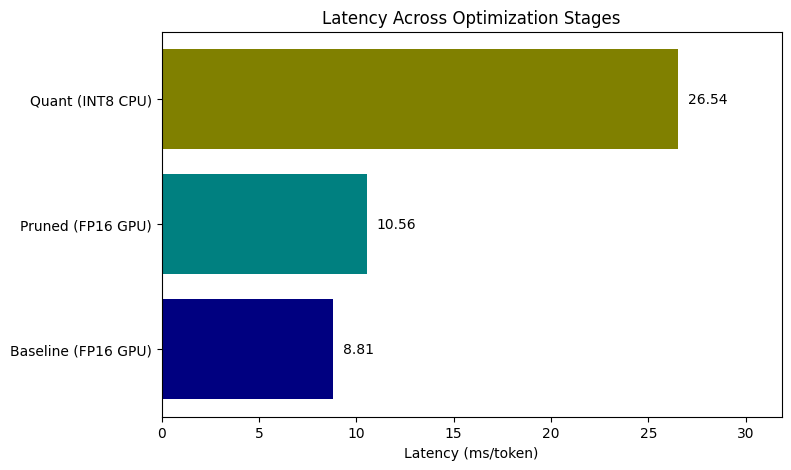

In [ ]:
import matplotlib.pyplot as plt

def plot_latency(metrics):
    """
    Plots a horizontal bar chart of latency values from different optimization stages.

    Args:
        metrics (dict): A dictionary containing model stages as keys and dictionaries as values.
                        Each inner dictionary should contain a 'latency' field indicating the
                        latency in milliseconds per token. For example:
                        
                        {
                            "Baseline (FP16 GPU)": {"latency": 12.5, "ppl": 40.03, "vram": 7.5},
                            "Pruned (FP16 GPU)":   {"latency": 10.2, "ppl": 55.54, "vram": 6.0},
                            "Quant (INT8 CPU)":    {"latency": 18.7, "ppl": 51.0,  "ram": 3.2}
                        }

    Returns:
        None. Displays a horizontal bar chart showing latency across optimization stages.

    TODO:
        1. Extract stage names from the metrics dictionary.
        2. Extract corresponding latency values for each stage.
        3. Use `matplotlib.pyplot` to create a horizontal bar chart.
        4. Label the x-axis as "Latency (ms/token)" and give an appropriate chart title.
        5. Annotate each bar with its exact latency value using `plt.text()`.
    """
    # TODO 1: Extract stage names

    # TODO 2: Extract latency values

    # TODO 3: Create horizontal bar chart

    # TODO 4: Label axes and title

    # TODO 5: Annotate each bar with its value

plot_latency(metrics)

### Plot Memory Usage (GPU VRAM vs CPU RAM)

All stages: ['Baseline (FP16 GPU)', 'Pruned (FP16 GPU)', 'Quant (INT8 CPU)']
 • Baseline (FP16 GPU): keys = ['latency', 'ppl', 'vram']
 • Pruned (FP16 GPU): keys = ['latency', 'ppl', 'vram']
 • Quant (INT8 CPU): keys = ['latency', 'ppl', 'ram']
GPU stages (with 'vram'): ['Baseline (FP16 GPU)', 'Pruned (FP16 GPU)']


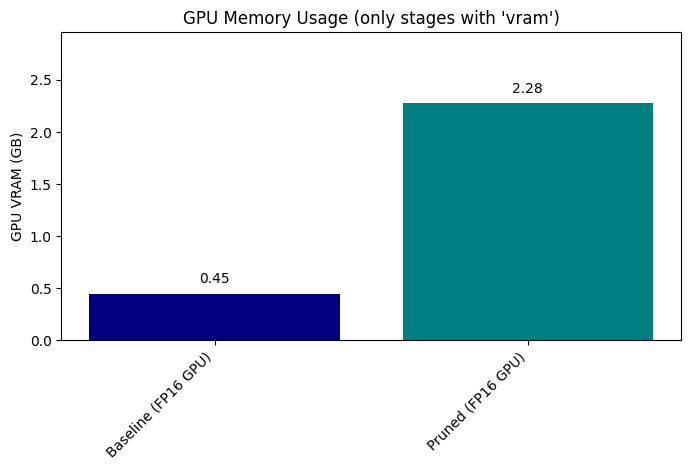

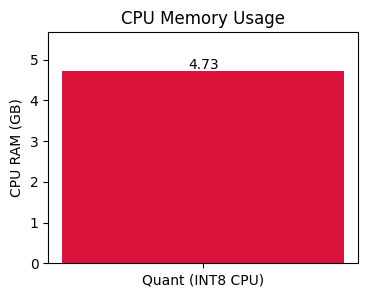

In [ ]:
import matplotlib.pyplot as plt

def plot_memory_usage(metrics):
    """
    Plots two separate bar charts:
      1. GPU VRAM usage for all stages that include a 'vram' key.
      2. CPU RAM usage for the stage named 'Quant (INT8 CPU)' which includes a 'ram' key.

    Args:
        metrics (dict): A dictionary of performance metrics per stage. Each key is a stage name,
                        and each value is a dictionary that may include:
                            - 'vram': GPU memory in GB
                            - 'ram':  CPU memory in GB
                            - Other metrics like 'latency', 'ppl', etc.

    Returns:
        None. Displays memory usage bar charts.

    TODO:
        1. Extract and print all stages and their keys for debugging.
        2. Filter out only those stages that include the 'vram' key.
        3. Plot GPU memory (VRAM) usage for those stages.
        4. If the stage "Quant (INT8 CPU)" has a 'ram' key, plot CPU RAM usage.
    """
    # TODO 1: Debug print

    # TODO 2: Filter stages that include 'vram'

    # TODO 3: Plot GPU VRAM usage

    # TODO 4: Plot CPU RAM usage if available

plot_memory_usage(metrics)

### Plot Perplexity Comparison

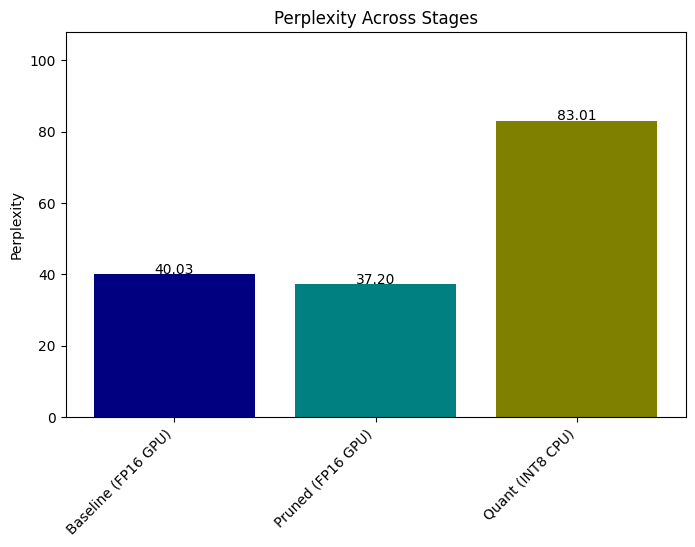

In [ ]:
import matplotlib.pyplot as plt

def plot_perplexity(metrics):
    """
    Plots a bar chart showing perplexity values across different model optimization stages.

    Args:
        metrics (dict): A dictionary where keys are stage names and values are dictionaries
                        containing various performance metrics. Each stage dictionary should
                        include a 'ppl' (perplexity) key. For example:

                        {
                            "Baseline (FP16 GPU)": {"latency": 12.5, "ppl": 40.03, "vram": 7.5},
                            "Pruned (FP16 GPU)":   {"latency": 10.2, "ppl": 55.54, "vram": 6.0},
                            "Quant (INT8 CPU)":    {"latency": 18.7, "ppl": 51.0,  "ram": 3.2}
                        }

    Returns:
        None. Displays a bar chart of perplexity values.

    TODO:
        1. Extract stage names from the metrics dictionary.
        2. Extract corresponding perplexity values for each stage.
        3. Use `matplotlib.pyplot` to plot a vertical bar chart.
        4. Annotate each bar with the corresponding perplexity value.
    """
    # TODO 1: Extract stage names

    # TODO 2: Extract perplexity values

    # TODO 3: Plot bar chart

    # TODO 4: Labeling

plot_perplexity(metrics)

#### Generate FLAME graphs using Tensorboard

### Run inference on CPU to predict next word

In [ ]:
import torch
import torch.nn.functional as F

def get_next_token_suggestions(
    model,
    tokenizer,
    prompt: str,
    top_k: int = 5
):
    """
    Returns the top_k most likely next‐token suggestions for a given prompt,
    based on the quantized CPU model’s logits.

    Args:
      model (INCModelForCausalLM): quantized GPT-2 on CPU
      tokenizer (AutoTokenizer): matching tokenizer
      prompt (str): the input text so far
      top_k (int): how many token suggestions to return

    Returns:
      List of (token_str, probability) tuples, sorted by descending probability.
    """
    # TODO: Implement the function to get next token suggestions
    pass


prompt_text = "Chelsea Football Club will win the Champions League and"
suggestions = get_next_token_suggestions(
    quant_model_cpu,
    tokenizer,
    prompt_text,
    top_k=3
)

print(f"Prompt: {prompt_text!r}\n")
print("Next-word suggestions (token ⟶ probability):")
for token_str, prob in suggestions:
    print(f"  {token_str!r} ⟶ {prob:.4f}")

Prompt: 'Chelsea Football Club will win the Champions League and'

Next-word suggestions (token ⟶ probability):
  'the' ⟶ 0.4807
  'FA' ⟶ 0.1367
  'Europa' ⟶ 0.0389
